# Molecule Alpha Simulations

Repository: https://gitlab.com/linumlabs/molecule-system-modelling

**What do we want to investigate given certain assumptions?**

1. Assuming a buy & hold investment behaviour, what tax rate results in reasonable investor break-even period and reaching the funding goal.
2. Given a certain tax rate, what user base and behaviour is needed to reach funding goal in given period.
3. How can we design the bonding curve such that the funding goal is reached within the given time allocated?
4. How can we design the tax such that investors are rewarded fairly, both early and late?
5. How can we fairly dissolve a project and redistribute its collateral when completed?

**In an ideal efficient market, we hope to:**

1. Reach the funding goal in the given period
2. Reward investors fairly
3. Promote further investment

**Funding outcomes can be any of the following, with certain consequences:**

Market creators
1. Funding reached within time period
2. Funding reached before time period
3. Funding not reached

Investors
1. Investors reach ROI
2. Investors make a profit
3. Investors make a loss

## Module imports

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import math
from scipy.optimize import fsolve
import scipy.integrate as integrate

from decimal import Decimal
import numpy as np
# from pynverse import inversefunc

import ipywidgets as widgets
from IPython.display import display

from abc import ABC, abstractmethod
from enum import Enum, auto
from functools import partial
import random
import uuid
import json

import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='BenjaminScholtz', api_key='8HheLHWEyoXDuLOiQ4ZO')

import sys
sys.path.append("../jupyter/lib/python3.7/site-packages")

In [30]:
params = {
    'tax_rate': [.05], # percentage
    'funding_period': [6], # months
    'funding_goal': [1_000_000], # dollars
    'max_holdings': [100_000],
}

# TODO: configure network

initial_conditions = {
    'investors': [100], # total for funding round
#     'supporters': []
    'trading_balance': [10_000], # dollars
}

# Example participant type
participant = {
    'type': 'investor',
    'trading_balance': 10_000, # dollars
    'holdings': 0, # dollar value of tokens
    'sentiment': 1, # 1 being hold indefinitely, 0 being sell immediately... tbd
}

default_gradient = 1/17_500.0
default_shift = 0.5

In [52]:
# monotonically increasing polynomial function
def bonding_function(x, m=default_gradient, c=default_shift):
#     return np.power(x, 2) + c
#     return np.multiply(m, x) + c
    C = 10
    a = 0.001
    return C * (1 - np.exp(-a*x)) + 1

# this is essentially numerical integration
#     return [np.sum(bonding_function(x[:index])) for index,_ in enumerate(x)]

# invariant function
def collateral_pool(x):
    return [integrate.quad(lambda i: bonding_function(i), x[0], x[index])[0] for index,_ in enumerate(x)]

def inverse_integral(x):
    matrix = np.column_stack((x,collateral_pool(x)))
    return np.linalg.inv(matrix)
    
def tax_function(x, m=default_gradient, c=default_shift):
#     return np.multiply(m, x) + c*(1 - params['tax_rate'][0])
    C = 10
    a = 0.001
    return C * (1 - np.exp(-a*x))

def final_collateral(x):
    return integrate.quad(lambda i: bonding_function(i), x[0], x[-1])

def vault_pool(x):
    return np.subtract(collateral_pool(x), [integrate.quad(lambda i: tax_function(i), x[0], x[index])[0] for index,_ in enumerate(x)])

def investor_pool(x):
    return np.subtract(collateral_pool(x), vault_pool(x))

In [58]:
x = np.linspace(0,10_000,10_00)

y = bonding_function(x)
t = tax_function(x)
c = collateral_pool(x)
v = vault_pool(x)
i = investor_pool(x)

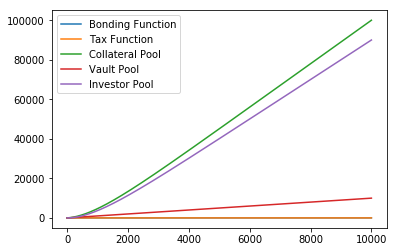

In [59]:
plt.plot(x, y, label='Bonding Function')
plt.plot(x, t, label='Tax Function')
plt.plot(x, c, label='Collateral Pool')
plt.plot(x, v, label='Vault Pool')
plt.plot(x, i, label='Investor Pool')
plt.legend(loc='upper left')
plt.show()

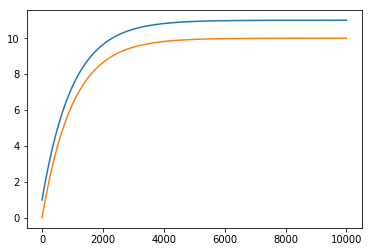

In [60]:
# Bonding function and tax (sell) function
plt.plot(x, y, x, t)
plt.show()

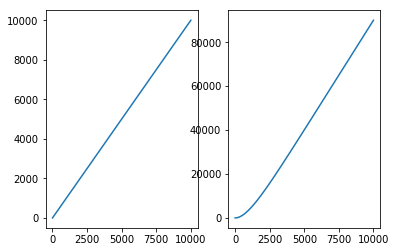

In [61]:
# Vault and investor pool
fig, axs = plt.subplots(1,2)

axs[0].plot(x, v)
axs[1].plot(x, i)

In [63]:
print(investor_pool([100,101,2000]))

[0.00000000e+00 9.56148499e-01 1.13049787e+04]


In [139]:
# Given a funding goal and period, 
bonding_function([1000.0])

array([0.55714286])

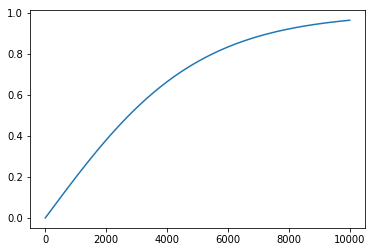

In [24]:
token_supply = 10_000
x = np.linspace(0,token_supply,1000)
y = np.tanh(x/(token_supply*.5))
plt.plot(x, y)
plt.show()

In [158]:
# plt.plot()
x = np.linspace(0,10_000,100_000)

matrix = np.column_stack((x,collateral_pool(x)))

inverse_integral(x)[:,0]

pynverse

LinAlgError: Last 2 dimensions of the array must be square

Given the funding goal and period, what parameters will help us reach that goal?

1. Tax rate
2. Total investment
3. Investor activity
4. Bonding curve

## Utility Functions

In [62]:
def id():
    return uuid.uuid4().int & (1<<64)-1

def bollinger_bands(value, window_size, num_of_std):

    rolling_mean = value.rolling(window=window_size).mean()
    rolling_std  = value.rolling(window=window_size).std()
    upper_band = rolling_mean + (rolling_std*num_of_std)
    lower_band = rolling_mean - (rolling_std*num_of_std)

    return rolling_mean, upper_band, lower_band

## Custom cadCAD type classes

In [ ]:
class StateType(Enum):
    @classmethod
    def initial_state(cls):
        _members = {}
        for item in cls.__members__:
            _members[cls[item]] = 0
        return _members
    
    def initial_conditions(cls):
        print("initial_conditions not implemented")

class ActionsType(Enum):
    def __init__(self, *args, **kwargs):
        pass
    
    def method(self, *args):
        method = getattr(self.__class__, '_%s' % self.name)
        return method(*args)

class PoliciesType:
    def list(self):
        policies = [func for func in dir(self) 
                    if (callable(getattr(self, func)) 
                        and func != 'list' 
                        and func.find('_'))]
        returnVal = {}
        for func in policies: returnVal[func] = getattr(self, func)
        return returnVal

In [ ]:
class ActionsExogenous(ActionsType):
    user_base_generator = auto()
    tx_volume_generator = auto()
    product_cost_generator = auto()
    
    @classmethod
    def _user_base_generator(cls, _g, step, sL, s, _input):
        y = StateExogenous.user_base
        x = max_user_base/(1 + math.pow(math.e, -(s['timestep'] - sigmoid_inflection)*sigmoid_slope))
        x = max(math.floor(x), 0)
        return (y, x)
    
    @classmethod
    def _tx_volume_generator(cls, _g, step, sL, s, _input):
        y = StateExogenous.tx_volume
        x = s[StateExogenous.tx_volume]*(1+2*eta*np.random.rand()*(1-s[StateExogenous.tx_volume]/tampw))
        return (y, x)
    
    @classmethod
    def _product_cost_generator(cls, _g, step, sL, s, _input):
        y = StateExogenous.product_cost
        x = alpha*s[StateExogenous.product_cost]+beta*np.random.rand() - costDecrease
        return (y, x)

## Model Simulation

In [57]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
from cadCAD.configuration import Configuration
import cadCadFunctions as c2F
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_state, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters, #dict containing simulation parameters
                       raw_exogenous_states=exogenous_states,
                       env_processes=env_processes,
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `main()` method returns a tuple; its first elements contains the raw results

%matplotlib inline
from matplotlib import cm
import pandas as pd

ModuleNotFoundError: No module named 'fn'

# Continuous Taxation

Tax rate set at a percentage per time period. For example 5% per month. See below re. block time.

From the Compound interest rate model:

See https://github.com/compound-finance/compound-money-market/blob/master/contracts/InterestRateModel.sol & https://github.com/compound-finance/compound-money-market

```    /**
      * @notice Gets the current supply interest rate based on the given asset, total cash and total borrows
      * @dev The return value should be scaled by 1e18, thus a return value of
      *      `(true, 1000000000000)` implies an interest rate of 0.000001 or 0.0001% *per block*.
      * @param asset The asset to get the interest rate of
      * @param cash The total cash of the asset in the market
      * @param borrows The total borrows of the asset in the market
      * @return Success or failure and the supply interest rate per block scaled by 10e18
*/
```

They use an interest rate based on `uint constant blocksPerYear = 2102400;`

Probably the best explanation of continuous tokens: https://yos.io/2018/11/10/bonding-curves/

First proposal:

1. Use a continuous token model, with a negative exponential function
2. A negative exponential function should dampen the effect seen in Protea where early investors are unfairly rewarded
3. When it comes time to dissolve the market, the connector weight can be set to 100% - essentially making all tokens the same price, and making the market entirely collateralized
4. A tax can be calculated as a function of block time, collateral pool size, funding goal, and funding period - optimized to reach a funding goal in the given period, no matter what